In [1]:
import os
import glob
import pickle
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Using a graph framework to visualize results

In [2]:
def onetoughjar(path2dic):
    with open(path2dic, 'rb') as pickle_file:
        try:
            while True:
                output = pickle.load(pickle_file)
        except EOFError:
            pass
    return(output)

In [3]:
dataPath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/tmp'

In [4]:
savedDict = onetoughjar(os.path.join(dataPath,'SSBABCDanalysisInt_11-26-2024_10-44-32'))

In [5]:
savedDict.keys()

dict_keys(['df', 'X', 'y', 'X_train', 'X_test', 'y_train', 'y_test', 'best_pipeline', 'X_reg', 'X_trainReg', 'X_testReg', 'y_trainReg', 'y_testReg', 'logistic', 'sigP', 'odds'])

In [23]:
interactions = list(savedDict['odds'].keys())

In [24]:
interactions

['rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_cor_ngd_df_scs_pllh',
 'rsfmri_cor_ngd_none_scs_cderh',
 'rsfmri_cor_ngd_sa_scs_thplh',
 'interview_age',
 'bmi_perc']

In [28]:
savedDict['odds']['rsfmri_c_ngd_cgc_ngd_cgc'].loc['int'][0]

3.78

In [6]:
df = savedDict['X']

In [7]:
df = df.join(savedDict['y'])

In [8]:
df.shape

(3700, 422)

In [9]:
# Subset rows where ssb_group == 1
subset_df_high = df[df['ssb_group'] == 1]

# Subset rows where ssb_group == 0
subset_df_low = df[df['ssb_group'] == 0]


In [10]:
subset_df_low.shape

(1850, 422)

In [11]:
subset_df_high.shape

(1850, 422)

In [123]:
subset_df_high['rsfmri_c_ngd_ad_ngd_cgc'].mean()

-0.0047478998919108836

In [124]:
subset_df_low['rsfmri_c_ngd_ad_ngd_cgc'].mean()

0.004747899962124177

In [125]:
df['rsfmri_c_ngd_ad_ngd_cgc'].mean()

3.5106647396763286e-11

In [12]:
brain = ['rsfmri_c_ngd_ad_ngd_cgc', 'rsfmri_c_ngd_ad_ngd_vs',
       'rsfmri_c_ngd_cgc_ngd_cgc', 'rsfmri_c_ngd_smh_ngd_smm',
       'rsfmri_c_ngd_sa_ngd_vta', 'rsfmri_cor_ngd_au_scs_aalh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'rsfmri_cor_ngd_au_scs_vtdcrh',
       'rsfmri_cor_ngd_cerc_scs_cdelh', 'rsfmri_cor_ngd_cerc_scs_ptlh',
       'rsfmri_cor_ngd_cerc_scs_aglh', 'rsfmri_cor_ngd_cerc_scs_vtdclh',
       'rsfmri_cor_ngd_cerc_scs_hprh', 'rsfmri_cor_ngd_cerc_scs_agrh',
       'rsfmri_cor_ngd_cerc_scs_vtdcrh', 'rsfmri_cor_ngd_copa_scs_thplh',
       'rsfmri_cor_ngd_copa_scs_vtdclh', 'rsfmri_cor_ngd_copa_scs_plrh',
       'rsfmri_cor_ngd_df_scs_ptlh', 'rsfmri_cor_ngd_df_scs_pllh',
       'rsfmri_cor_ngd_df_scs_aalh', 'rsfmri_cor_ngd_none_scs_ptlh',
       'rsfmri_cor_ngd_none_scs_thprh', 'rsfmri_cor_ngd_none_scs_cderh',
       'rsfmri_cor_ngd_rst_scs_bs', 'rsfmri_cor_ngd_rst_scs_thprh',
       'rsfmri_cor_ngd_rst_scs_hprh', 'rsfmri_cor_ngd_rst_scs_vtdcrh',
       'rsfmri_cor_ngd_smh_scs_crcxlh', 'rsfmri_cor_ngd_smh_scs_pllh',
       'rsfmri_cor_ngd_smh_scs_cderh', 'rsfmri_cor_ngd_smh_scs_ptrh',
       'rsfmri_cor_ngd_smh_scs_hprh', 'rsfmri_cor_ngd_smh_scs_aarh',
       'rsfmri_cor_ngd_smm_scs_hplh', 'rsfmri_cor_ngd_smm_scs_aglh',
       'rsfmri_cor_ngd_smm_scs_thprh', 'rsfmri_cor_ngd_sa_scs_crcxlh',
       'rsfmri_cor_ngd_sa_scs_thplh', 'rsfmri_cor_ngd_vta_scs_hplh',
       'rsfmri_cor_ngd_vs_scs_hplh', 'rsfmri_cor_ngd_vs_scs_thprh',
       'rsfmri_cor_ngd_vs_scs_plrh', 'rsfmri_cor_ngd_vs_scs_hprh']

In [29]:
def graphList (cols, df):
    edges = []
    for x in cols:
        y = x.split('_')
        ROI1 = y[3]
        ROI2 = y[5]
        ser = (ROI1, ROI2, {"weight": df[x].mean(), "SD":df[x].std()})
        if x in interactions:
            ser[2].update({'odds':savedDict['odds']['%s'%x].loc['int'][0]})
        edges.append(ser)
    return(edges)

In [30]:
highEdgeList = graphList(brain, subset_df_high)
lowEdgeList = graphList(brain, subset_df_low)

In [31]:
lowEdgeList

[('ad', 'cgc', {'weight': 0.004747899962124177, 'SD': 0.06060942808486202}),
 ('ad', 'vs', {'weight': -0.0074574915018626765, 'SD': 0.06367832052830119}),
 ('cgc',
  'cgc',
  {'weight': 0.008541586555722442, 'SD': 0.0748253205365792, 'odds': 3.78}),
 ('smh', 'smm', {'weight': -0.01511705231351352, 'SD': 0.08429114981624154}),
 ('sa', 'vta', {'weight': 0.005609846274723158, 'SD': 0.06887708523625574}),
 ('au', 'aalh', {'weight': 0.013021626844406144, 'SD': 0.08851399775929505}),
 ('au', 'ptrh', {'weight': 0.01703300125081081, 'SD': 0.11100303132580129}),
 ('au',
  'vtdcrh',
  {'weight': -0.008363839459354276, 'SD': 0.07199299735612413}),
 ('cerc', 'cdelh', {'weight': 0.01565711496486485, 'SD': 0.09791022305825017}),
 ('cerc', 'ptlh', {'weight': 0.016923746387567558, 'SD': 0.11469448768518864}),
 ('cerc', 'aglh', {'weight': 0.014528564686486481, 'SD': 0.10028255334844878}),
 ('cerc',
  'vtdclh',
  {'weight': -0.010127031317297286, 'SD': 0.11971813382030237}),
 ('cerc', 'hprh', {'weight':

In [121]:
highEdgeList

[('ad', 'cgc', {'weight': -0.0047478998919108836, 'SD': 0.059368184900265825}),
 ('ad', 'vs', {'weight': 0.007457492344382763, 'SD': 0.06986838775110593}),
 ('cgc',
  'cgc',
  {'weight': -0.008541586644864842, 'SD': 0.07669294438922114, 'odds': 3.78}),
 ('smh', 'smm', {'weight': 0.015117051945945956, 'SD': 0.10383596479751403}),
 ('sa', 'vta', {'weight': -0.005609846519935716, 'SD': 0.06843173815468159}),
 ('au', 'aalh', {'weight': -0.013021627157837824, 'SD': 0.10149052277927524}),
 ('au', 'ptrh', {'weight': -0.017033001381525203, 'SD': 0.13009874225571375}),
 ('au', 'vtdcrh', {'weight': 0.008363839066699782, 'SD': 0.08048389219512306}),
 ('cerc', 'cdelh', {'weight': -0.01565711529180132, 'SD': 0.1126415996753042}),
 ('cerc', 'ptlh', {'weight': -0.0169237454340541, 'SD': 0.14629201627278984}),
 ('cerc',
  'aglh',
  {'weight': -0.014528564668106656, 'SD': 0.11732668119985805}),
 ('cerc',
  'vtdclh',
  {'weight': 0.010127031217921122, 'SD': 0.1387266474760023}),
 ('cerc',
  'hprh',
  {'

In [32]:
lowG = nx.Graph()
highG = nx.Graph()


In [33]:
# Add edges to the graph
lowG.add_edges_from(lowEdgeList)
highG.add_edges_from(highEdgeList)


In [44]:
interactions

['rsfmri_c_ngd_cgc_ngd_cgc',
 'rsfmri_cor_ngd_df_scs_pllh',
 'rsfmri_cor_ngd_none_scs_cderh',
 'rsfmri_cor_ngd_sa_scs_thplh',
 'interview_age',
 'bmi_perc']

In [35]:
import seaborn as sns

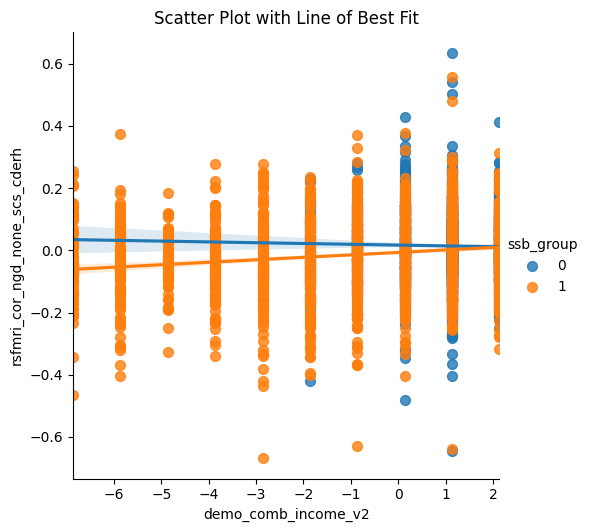

In [144]:
# Scatter plot with line of best fit for each group
sns.lmplot(
    x='demo_comb_income_v2',
    y='rsfmri_cor_ngd_none_scs_cderh',
    hue='ssb_group',
    data=savedDict['df'],
    ci=95,
    scatter_kws={"s": 50}
)
plt.title('Scatter Plot with Line of Best Fit')
plt.show()

In [ ]:
def grapher():
    pos = nx.spring_layout(G, seed=seed)

In [57]:
G.nodes(data = True)

NodeDataView({'ad': {}, 'cgc': {}, 'vs': {}, 'smh': {}, 'smm': {}, 'sa': {}, 'vta': {}, 'au': {}, 'aalh': {}, 'ptrh': {}, 'vtdcrh': {}, 'cerc': {}, 'cdelh': {}, 'ptlh': {}, 'aglh': {}, 'vtdclh': {}, 'hprh': {}, 'agrh': {}, 'copa': {}, 'thplh': {}, 'plrh': {}, 'df': {}, 'pllh': {}, 'none': {}, 'thprh': {}, 'cderh': {}, 'rst': {}, 'bs': {}, 'crcxlh': {}, 'aarh': {}, 'hplh': {}})

In [96]:
def grapher(g):
    import matplotlib.pyplot as plt
    import networkx as nx
    import matplotlib as mpl
    
    # Set plot size
    plt.figure(figsize=(12, 8))  # Width=12, Height=8

    # Create a graph
    G = g

    # Extract edge attributes
    weights = nx.get_edge_attributes(G, 'weight')
    odds = nx.get_edge_attributes(G, 'odds')

    # Normalize edge weights for coloring
    edge_colors = [weights.get(edge, 0) for edge in G.edges]  # Default to 0 if no weight
    edge_colors2 = [odds.get(edge, 0) for edge in G.edges]    # Default to 0 if no odds

    # Plot the graph
    pos = nx.spring_layout(G)  # Layout for better visualization

    # Draw the nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=500)
    nx.draw_networkx_labels(G, pos)

    # Draw edges based on odds
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[edge for edge in G.edges if edge in odds],  # Only edges with odds
        edge_color=[odds[edge] for edge in G.edges if edge in odds],
        edge_cmap=plt.cm.Wistia,
        edge_vmin=min(edge_colors2),  # Explicitly normalize to odds range
        edge_vmax=max(edge_colors2),  # Explicitly normalize to odds range
        width=10,
    )
    
    # Draw edges based on weights
    nx.draw_networkx_edges(
        G, pos,
        edgelist=[edge for edge in weights],  # Only edges with weights
        edge_color=[weights[edge] for edge in weights],
        edge_cmap=plt.cm.cool,
        edge_vmin=min(edge_colors),  # Explicitly normalize to weight range
        edge_vmax=max(edge_colors),  # Explicitly normalize to weight range
        width=2,
    )

    # Add colorbar for weights
    sm_weights = mpl.cm.ScalarMappable(cmap=plt.cm.cool, norm=mpl.colors.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm_weights.set_array([])
    cbar_weights = plt.colorbar(sm_weights, label='Edge Weight', pad=0.01)
    
    # Add colorbar for odds
    sm_odds = mpl.cm.ScalarMappable(cmap=plt.cm.Wistia, norm=mpl.colors.Normalize(vmin=min(edge_colors2), vmax=max(edge_colors2)))
    sm_odds.set_array([])
    cbar_odds = plt.colorbar(sm_odds, label='Edge Odds', pad=0.1)

    plt.title("Graph with Edge Colors Based on Weights and Odds")
    plt.show()


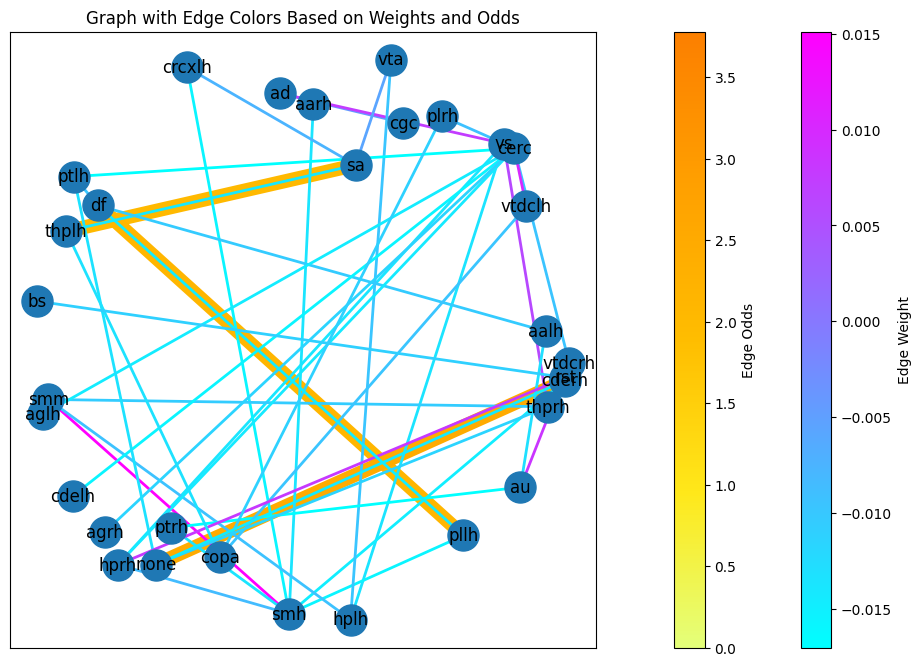

In [98]:
grapher(highG)

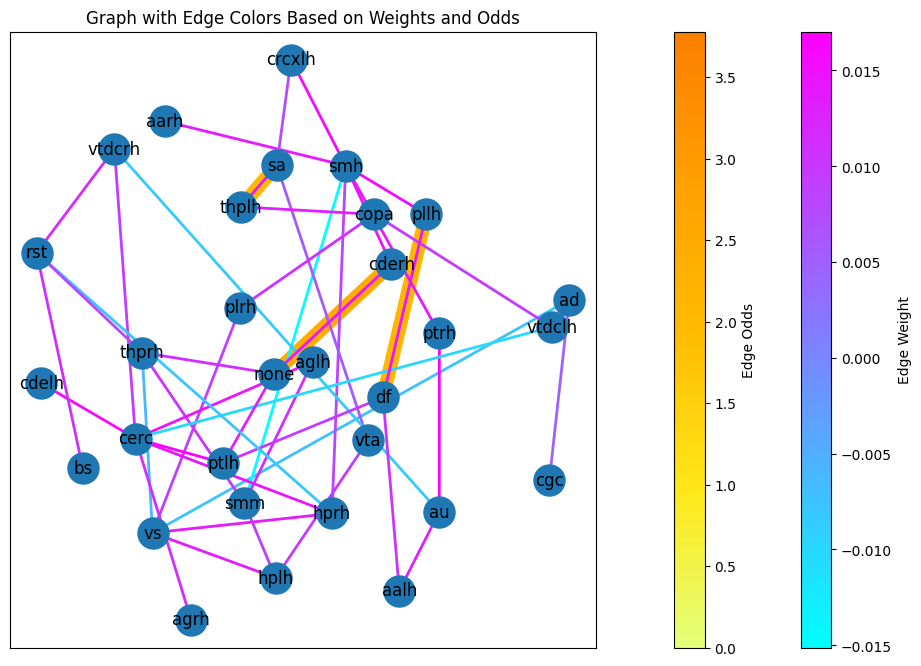

In [129]:
grapher(lowG)